### Data Collection

This project collected data from the [Taylor Swift Lyrics dataset](
https://www.kaggle.com/datasets/ishikajohari/taylor-swift-all-lyrics-30-albums) available on Kaggle, which includes the album, song title, and lyrics for each song. For this project, only a selection of 10 albums will be utilized, as they are considered to be Taylor Swift's primary albums.

This section of the code performs preprocessing on the lyrics, which involves removing punctuation, spell-checking the text, and then appending it to a CSV file called "song_lyrics_df_v1.csv" to consolidate the lyrics and song titles.

The Spotify stream counts are obtained from [Kworb.net](https://kworb.net/spotify/artist/06HL4z0CvFAxyc27GXpf02_songs.html) and are manually added to the CSV file. Additionally, the album release years are entered manually and gathered from [Music Fandom](
https://music.fandom.com/wiki/Taylor_Swift_discography) and [The Reading Order](https://www.thereadingorder.com/taylor-swift-albums-in-order/).

In [26]:
import os
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification


In [27]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Spell checking
    spell = SpellChecker()
    tokens = [spell.correction(token) for token in tokens if spell.correction(token) is not None]
    
    # Join tokens back into a single string
    preprocessed_text = " ".join(tokens)
    
    return preprocessed_text

In [28]:
def preprocess_lyrics(folder_path):
    albums = os.listdir(folder_path)
    preprocessed_lyrics = []
    song_titles = []
    
    for album in albums:
        album_path = os.path.join(folder_path, album)
        
        if not os.path.isdir(album_path):
            continue
        
        songs = os.listdir(album_path)
        
        # print(album_path)
        for song in songs:
            # print(song)
            song_path = os.path.join(album_path, song)
            
            if not song.endswith(".txt"):
                continue
            
            with open(song_path, "r") as file:
                lines = file.readlines()
            
            if len(lines) < 2:
                continue
            
            lyrics = "".join(lines[1:])  # Remove the first line
            
            preprocessed_lyrics.append(preprocess_text(lyrics))
            song_titles.append(song[:-4])
    
    return preprocessed_lyrics, song_titles

In [29]:
# Provide the path to the albums folder
folder_path = "./data/Core"

# Preprocess lyrics
preprocessed_lyrics, song_titles = preprocess_lyrics(folder_path)

In [30]:
# print(song_titles)
# print(preprocessed_lyrics)

#Create DataFrame
columns=['Song','Lyrics']
df = pd.DataFrame(list(zip(song_titles, preprocessed_lyrics)),
                 columns=columns)

# print(df.head(5))

# df.to_csv('song_lyrics_df_v1.csv', index=False)

### Labelling Songs

*skip this part and run the next section to load the analysis results to be used for report generation*

The song_lyrics_df.csv dataset, which was generated in the previous section of this notebook, is loaded along with the manually inputted data. 

In this section, sentiment analysis is performed on the lyrics, and the resulting sentiment scores are exported to a CSV file.
Running the following models:
1. 'bhadresh-savani/distilbert-base-uncased-emotion': 'DistilBERT Emotion'
2. 'bhadresh-savani/albert-base-v2-emotion': 'AlBERT base Emotion'
3. 'bhadresh-savani/electra-base-emotion' : 'Electra base Emotion'


In [31]:
import pandas as pd
from transformers import pipeline

In [32]:
df = pd.read_csv('song_lyrics_df.csv')

In [33]:
#df

In [34]:
# Perform sentiment analysis on each song using different models from the Hugging Face library
models = {
    'bhadresh-savani/distilbert-base-uncased-emotion': 'DistilBERT Emotion',
    'bhadresh-savani/albert-base-v2-emotion': 'AlBERT base Emotion',
    'bhadresh-savani/electra-base-emotion' : 'Electra base Emotion'
    
}

# Initialize a dictionary to store the dataframes for each model
model_dataframes = {}

for model_name, model_label in models.items():
    model = pd.DataFrame({'Album': [], 
                    'Song': [], 
                    'Year': [], 
                    'Total_Streams': [], 
                    'Daily': []})
    
    for index in df.index:
        lyrics = df['Lyrics'][index]
        
        # fill information
        model.at[int(index),'Album'] = df['Album'][index] 
        model.at[int(index),'Song'] = df['Song'][index] 
        model.at[int(index),'Year'] = df['Year'][index] 
        model.at[int(index),'Total_Streams'] = df['Total_Streams'][index]
        model.at[int(index),'Daily'] = df['Daily'][index]
        
        # sentiment analysis
        sentiment_analysis = pipeline("sentiment-analysis", model=model_name, top_k=None)
        sentiments = sentiment_analysis(lyrics)

        model.at[int(index), 'BestEmotion'] = sentiments[0][0]['label']

        for sentiment in sentiments[0]:
            model.at[int(index), sentiment['label']] = sentiment['score']

    model_dataframes[model_label] = model


In [35]:
model_dataframes['AlBERT base Emotion']
model_dataframes['AlBERT base Emotion'].to_csv('AlBERT.csv', index=False)

In [36]:
model_dataframes['DistilBERT Emotion']
model_dataframes['DistilBERT Emotion'].to_csv('DistilBERT.csv', index=False)

In [37]:
model_dataframes['Electra base Emotion']
model_dataframes['Electra base Emotion'].to_csv('Electra.csv', index=False)

## Reports Section

#### Import Dataframe values
This section imports the sentiment analysis data from the models to be used to generate reports.

In [38]:
import pandas as pd
model_dataframes = {}
model_dataframes['DistilBERT Emotion'] = pd.read_csv('DistilBERT.csv')
model_dataframes['AlBERT base Emotion'] = pd.read_csv('AlBERT.csv')
model_dataframes['Electra base Emotion'] = pd.read_csv('Electra.csv')

### Evaluation of models

song_emotions are 34 randomly picked songs which are tagged and labelled manually as "ground truth".

In [39]:
song_emotions = {
    '22': ['joy', 'love', 'surprise'],
    'Afterglow': ['fear', 'love'],
    'AllTooWell': ['sadness', 'anger'],
    'APerfectlyGoodHeart': ['sadness'],
    'BacktoDecember': ['sadness', 'love'],
    'betty': ['sadness'],
    'champagneproblems': ['sadness', 'surprise'],
    'CorneliaStreet': ['love', 'sadness'],
    'Daylight': ['joy', 'love'],
    'DontBlameMe': ['anger', 'love'],
    'Enchanted': ['joy', 'love', 'surprise'],
    'EndGame': ['love'],
    'ForeverAndAlways': ['anger', 'love'],
    'IForgotThatYouExisted': ['anger', 'love', 'surprise'],
    'IThinkHeKnows': ['love', 'surprise'],
    'KingofMyHeart': ['love', 'joy'],
    'Gorgeous': ['joy', 'love'],
    'ItsNicetoHaveaFriend': ['joy'],
    'LavenderHaze': ['joy', 'love'],
    'Lover': ['joy', 'love'],
    'LoveStory': ['joy', 'love', 'surprise'],
    'Maroon': ['sadness', 'love'],
    'ME': ['joy', 'love', 'surprise'],
    'OutOfTheWoods': ['fear', 'love'],
    'PaperRings': ['joy', 'love'],
    'PicturetoBurn': ['anger', 'love'],
    'ShakeItOff': ['joy', 'surprise'],
    'SpeakNow': ['love', 'fear'],
    'SweetNothing': ['joy', 'love'],
    'TimMcGraw': ['sadness', 'love'],
    'VigilanteShit': ['anger', 'sadness'],
    'WelcometoNewYork': ['joy', 'surprise'],
    'WeAreNeverEverGettingBackTogether': ['anger', 'joy'],
    'YoureOnYourOwnKid': ['sadness', 'fear'],
}

In [40]:
def calculate_accuracy(song, emotions, dataframe):
    #print(dataframe)
    song_scores = dataframe.loc[dataframe['Song'] == song, emotions].values[0]
    max_score_emotion = emotions[song_scores.argmax()]
    return max_score_emotion == song_emotions[song][0]


In [41]:
# Calculate accuracy for each DataFrame and store the results in a list
accuracy_results = []
for dataframe in model_dataframes.values():
    accuracy = 0
    for song, emotions in song_emotions.items():
        accuracy += calculate_accuracy(song, emotions, dataframe)
    accuracy_results.append(accuracy / len(song_emotions))

In [42]:
# Assuming accuracy_results is a list of accuracies in the same order as model_dataframes.keys()
data_frames = list(model_dataframes.keys())
accuracies = accuracy_results

# Generating the report
print("-------- Accuracy Report --------")
for df, accuracy in zip(data_frames, accuracies):
    print(f"DataFrame: {df}")
    print(f"Accuracy: {accuracy}")
    print("---------------------------------")


-------- Accuracy Report --------
DataFrame: DistilBERT Emotion
Accuracy: 0.7058823529411765
---------------------------------
DataFrame: AlBERT base Emotion
Accuracy: 0.7352941176470589
---------------------------------
DataFrame: Electra base Emotion
Accuracy: 0.7647058823529411
---------------------------------


# Analysis

### A Sentimental Dreamweaver - Taylor's Song Distribution by Emotion

 In the album "1989," there is a notable presence of "joy" alongside a significant emphasis on "sadness." This suggests a range of emotional experiences and reflections within the album. Moving on to "Evermore," we observe a relatively low occurrence of "anger" but a higher focus on "sadness," indicating a somber and introspective tone. In "Fearless," there is a combination of "joy" and "sadness," possibly representing a contrast between uplifting and melancholic moments. "Folklore" stands out with instances of "anger," "fear," and "sadness," suggesting a deeper exploration of complex and darker emotions. The album "Lover" exhibits a mix of emotions, including "fear," "joy," "love," and a notable presence of "sadness," which may reflect a range of romantic experiences. "Midnights" showcases a balance between "joy" and "sadness," possibly conveying a sense of introspection and reflection during nighttime. In "Red," we see a diverse range of emotions with instances of "anger," "fear," "joy," "love," and a significant focus on "sadness," indicating a wide emotional spectrum. "Reputation" leans more towards "sadness" and "joy" while featuring a minor presence of "fear," potentially exploring themes of reputation, vulnerability, and personal growth. Finally, "SpeakNow" is characterized by instances of "anger," "fear," and "sadness," suggesting a mix of intense and emotional experiences. By grouping the data by albums and examining the emotional themes present, we gain insights into the overarching emotional journeys conveyed in each album.

In [43]:
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
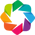

:Chord   [Album,BestEmotion]   (Count)

In [44]:
hv.extension('bokeh')
hv.output(size=200)

model = model_dataframes['Electra base Emotion']

grouped_df = model.groupby(['Album', 'BestEmotion']).size().reset_index(name='Count')
chord = hv.Chord(grouped_df, ['Album', 'BestEmotion'], 'Count')

chord.opts(
    opts.Chord(cmap='Category10', edge_cmap='Category10', edge_color=dim('BestEmotion').str(), labels='index', node_color=dim('index').str()),
    opts.Labels(text_color='black', text_font_size='10pt'),
)

chord

### A Famed Lyricist - Vocabulary of a Pop Star

Word cloud visual representation of commonly used words found in lyrics according to their frequency or importance. Words like 'love', 'never', 'cause', 'night', and 'see' among many others are prevalent in Taylor's song writing. These words can build upon themes of emotions that resonate to her fans and audiences.

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

(-0.5, 499.5, 499.5, -0.5)

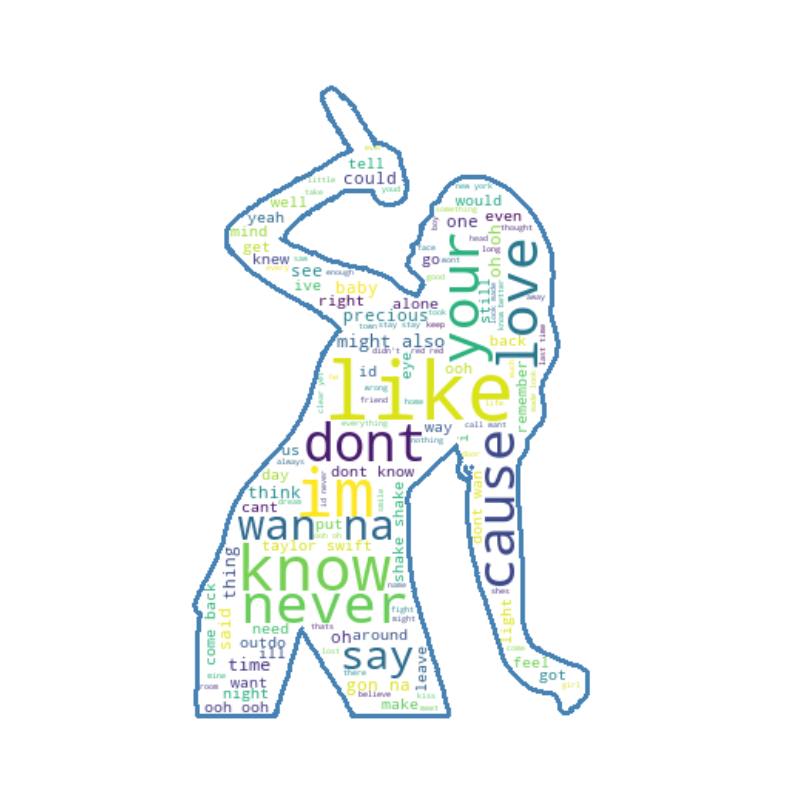

In [46]:
text = open('song_lyrics_df.csv').read()
stopwords = ['chorus', 'verse', 'outro', 'intro', 'bridge']
taylor_mask = np.array(Image.open("taylorswift_sillhouette.png"))
wc = WordCloud(background_color="white", max_words=2000, mask=taylor_mask,
               stopwords=stopwords, contour_width=2, contour_color='steelblue', width=1600, height=800)

# generate word cloud
wc.generate(text)
# store to file
wc.to_file("taylor_wc.png")

# show
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")


### An Emotional Writer - Taylor's Emotional Song Variety Throughout her Discography

Emotion distribution of each albums throughout her collection.

As seen on the graphs below, the 3 models gathered different results from the collated tagged best emotions in each album.

DistilBERT:Joy is one of the leading emotions across the albums followed by sadness.

Electra:Sadness is the leading emotion found across her albums, followed by joy. Surprisingly, love is the lowest tagged emotion through her album.

AlBERTa:Joy is the most common emotion found across her albums, followed by a scattered scores for love, anger and sadness.

The three datasets (alBERT, DistilBERT, and Electra) exhibit variations in emotional distributions across Taylor Swift's albums. In the alBERT dataset, emotions such as anger, joy, and sadness are well-represented, with joy being the most prevalent. The DistilBERT dataset introduces additional emotions such as surprise and fear, while adjusting the counts for certain emotions compared to the alBERT dataset. In this dataset, joy remains prominent, but sadness appears to be more prevalent than anger. The Electra dataset further diverges by emphasizing emotions like sadness and joy, with a significant increase in the count of sadness in some albums. Fear also emerges as a distinct emotion in certain songs. Overall, the datasets demonstrate differences in emotion representation and highlight the variations in emotional themes captured by different models.

In [47]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

album_order = [
    "TaylorSwift",
    "Fearless",
    "SpeakNow",
    "Red",
    "1989",
    "Reputation",
    "Lover",
    "Folklore",
    "Evermore",
    "Midnights"
]

colors = {
    'joy': '#FFB347',      # Pastel Orange
    'love': '#FF7F50',     # Pastel Coral
    'sadness': '#87CEEB',  # Pastel Sky Blue
    'anger': '#FF7373',    # Pastel Salmon
    'surprise': '#B19CD9', # Pastel Lavender
    'fear': '#9ACD32'      # Pastel Yellow Green
}

def create_graph(model_name):
    model = model_dataframes[model_name]
    grouped_df = model.groupby(['Album', 'BestEmotion']).size().reset_index(name='Count')

    emotions = grouped_df['BestEmotion'].unique()

    grouped_df['Album'] = pd.Categorical(grouped_df['Album'], categories=album_order, ordered=True)
    grouped_df.sort_values('Album', inplace=True)

    fig = go.Figure()

    for emotion in emotions:
        df = grouped_df[grouped_df['BestEmotion'] == emotion]
        fig.add_trace(go.Scatter(x=df['Album'], y=df['Count'], mode='lines+markers', name=emotion, line=dict(color=colors[emotion])))

    fig.update_layout(
        title=f'Emotion Distribution by Album labelled by {model_name}',
        xaxis_title='Album',
        yaxis_title='Count',
        xaxis={'tickangle': 90},
        showlegend = False
    )
    
    return fig

fig1 = create_graph('DistilBERT Emotion')
fig2 = create_graph('AlBERT base Emotion')
fig3 = create_graph('Electra base Emotion')

fig = make_subplots(rows=3, cols=1, subplot_titles=('DistilBERT Emotion', 'AlBERT base Emotion', 'Electra base Emotion'))

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
    

for trace in fig2.data:
    fig.add_trace(trace, row=2, col=1)

for trace in fig3.data:
    fig.add_trace(trace, row=3, col=1)

fig.update_layout(height=900,legend_title='Emotion',showlegend=True)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

fig.show(renderer='notebook')




### What Resonates to Swifties - Emotions by Stream Count

The graph below shoes the Spotify Streams by Album with disected emotions. We're displaying results from the AlBERT base Emotion where fear and anger are apparent in the albums with the most streams - 1989, Reputation and Lover. Followed by Folklore, midights and Evermore where sadness plays a big role in the albums.

The analysis reveals interesting insights about Taylor Swift's albums and their associated best emotions and total stream counts. Among her albums, "1989" emerges as the most streamed, with joy and sadness being the predominant emotions. Notably, "Evermore" resonates with listeners through its expression of anger, joy, and sadness, with sadness accumulating the highest total stream count. The album "Fearless" strikes a chord with emotions such as fear, joy, and sadness, with sadness garnering the highest stream count. "Folklore" encompasses a wide range of emotions, including anger, fear, joy, and sadness, with sadness leading in terms of total streams. "Lover" captivates listeners with joy, sadness, and love, while sadness prevails as the most streamed emotion. "Midnights" presents a mix of anger, joy, and sadness, with sadness taking the lead in total streams. In the album "Red," emotions like anger, fear, joy, love, and sadness coexist, with sadness accumulating the highest stream count. The album "Reputation" showcases emotions of fear, joy, and sadness, with sadness amassing the highest total stream count. Lastly, "SpeakNow" elicits emotions of anger, fear, joy, and sadness, with sadness garnering the highest total stream count.

In [48]:
import plotly.graph_objects as go

model = model_dataframes['Electra base Emotion']
model['Total_Streams'] = model['Total_Streams'].replace(',','', regex=True).astype('int')
grouped_df = model.groupby(['Album', 'BestEmotion'])['Total_Streams'].sum().reset_index()

emotions = grouped_df['BestEmotion'].unique()

album_order = [
    "TaylorSwift",
    "Fearless",
    "SpeakNow",
    "Red",
    "1989",
    "Reputation",
    "Lover",
    "Folklore",
    "Evermore",
    "Midnights"
]

# Define colors for each emotion
colors = {
    'joy': '#FFB347',      # Pastel Orange
    'love': '#FF7F50',     # Pastel Coral
    'sadness': '#87CEEB',  # Pastel Sky Blue
    'anger': '#FF7373',    # Pastel Salmon
    'surprise': '#B19CD9', # Pastel Lavender
    'fear': '#9ACD32'      # Pastel Yellow Green
}

# Sort the grouped_df DataFrame based on album_order
grouped_df['Total Streams'] = pd.Categorical(grouped_df['Album'], categories=album_order, ordered=True)
grouped_df.sort_values('Album', inplace=True)

fig = go.Figure()

for emotion in emotions:
    df_emotion = grouped_df[grouped_df['BestEmotion'] == emotion]
    fig.add_trace(go.Bar(
        x=df_emotion['Album'],
        y=df_emotion['Total_Streams'],
        name=emotion,
        marker_color=colors[emotion]  # Set the color for each bar based on emotion
    ))

fig.update_layout(
    barmode='stack',
    title='Spotify Streams by Album Emotions',
    xaxis_title='Album',
    yaxis_title='Total Streams',
    xaxis={'tickangle': 90},
    legend_title='Emotion'
)

fig.update_xaxes(categoryorder='array', categoryarray = album_order)
fig.show(renderer='notebook')